<a href="https://colab.research.google.com/github/nannthd/project_AIEngineer/blob/main/vector_drug_ResNet50%26YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

def unzip_file(zip_file, extract_folder):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print(f"ไฟล์ {zip_file} ถูก unzip ไปที่ {extract_folder} แล้ว")

# ตัวอย่างการใช้งาน
zip_file = '/content/drive/MyDrive/drug/drug50cls_640.zip'  # เปลี่ยนเป็นชื่อไฟล์ที่ต้องการ unzip
extract_folder = '/content/drug50cls_640'  # เปลี่ยนเป็นโฟลเดอร์ที่ต้องการที่จะ extract ไฟล์ไปที่นั่น

unzip_file(zip_file, extract_folder)

##ไม่ใช้YOLO

In [13]:
# ใช้โค้ดนี้
import pandas as pd
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from PIL import Image

# ใช้โมเดล ResNet50 ของ TensorFlow ในการทำ embedding
model = ResNet50(include_top=False, weights='imagenet', pooling='avg')

def image_embedding(path):
    img = Image.open(path)
    img = img.resize((640, 640))  # ปรับขนาดภาพให้เข้ากับ ResNet50
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    curr_df = pd.DataFrame(preds[0]).T
    return curr_df

def load_embeddings_from_csv(csv_folder):
    all_embeddings = {}
    for csv_file in os.listdir(csv_folder):
        if csv_file.endswith('.csv'):
            class_name = os.path.splitext(csv_file)[0]  # ใช้ชื่อไฟล์ CSV เป็นชื่อคลาส
            csv_path = os.path.join(csv_folder, csv_file)
            df = pd.read_csv(csv_path)
            # ดรอปคอลัมน์ ID และเก็บเฉพาะเวกเตอร์ของคลาส
            embeddings_no_id = df.drop(['ID'], axis=1)
            all_embeddings[class_name] = embeddings_no_id
    return all_embeddings

def find_most_similar_classes(new_image_path, all_embeddings):
    new_embedding = image_embedding(new_image_path)
    similarity_scores = {}

    for class_name, embeddings_df in all_embeddings.items():
        # คำนวณค่า similarity ระหว่าง embedding ของรูปภาพใหม่กับ embeddings ของคลาส
        similarity_score = cosine_similarity(new_embedding, embeddings_df)
        max_similarity_score = similarity_score.max()  # หา similarity ที่สูงที่สุดในคลาส
        similarity_scores[class_name] = max_similarity_score

    sorted_similarity = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    top_5_similar_classes = sorted_similarity[:5]

    return top_5_similar_classes

# โหลด embedding จากโฟลเดอร์ที่เก็บไฟล์ CSV
csv_folder_path = '/content/drug50cls_640'
all_embeddings = load_embeddings_from_csv(csv_folder_path)

# รูปภาพที่ต้องการทดสอบ
new_image_path = '/content/1.jpg'

# ค้นหาคลาสที่มีความคล้ายกันที่สุด 5 อันดับ
similar_classes = find_most_similar_classes(new_image_path, all_embeddings)

# แสดงผลลัพธ์
print("Top 5 most similar classes:")
for rank, (class_name, similarity_score) in enumerate(similar_classes, start=1):
    print(f"{rank}. Class: {class_name}, Similarity Score: {similarity_score}")

1/1 [==============================] - 2s 2s/step
Top 5 most similar classes:
1. Class: Janumet50_1000mg, Similarity Score: 0.7697937031176645
2. Class: Amlopine5mg, Similarity Score: 0.756331928649153
3. Class: BlopressPlus8mg, Similarity Score: 0.7547976022663783
4. Class: Amlopine10mg, Similarity Score: 0.7406243538814581
5. Class: Caduet10_10mg, Similarity Score: 0.7228856744360195


##ใช้YOLO

In [ ]:
!pip install ultralytics

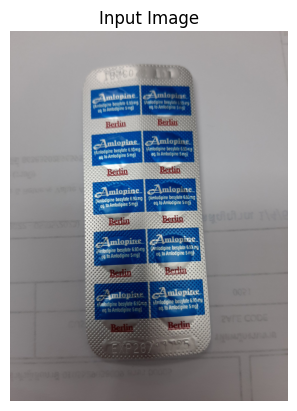


0: 640x480 1 Amlopine_5mg, 498.0ms
Speed: 7.3ms preprocess, 498.0ms inference, 14.2ms postprocess per image at shape (1, 3, 640, 480)


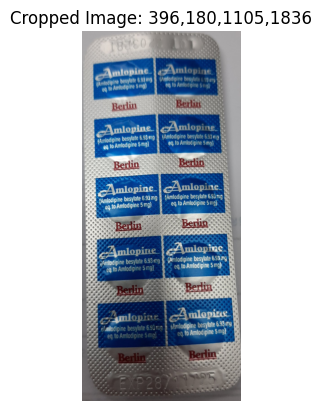

1/1 [==============================] - 3s 3s/step
Top 5 most similar classes:
1. Class: Amlopine5mg, Similarity Score: 0.8723766088556295
2. Class: Betalol40mg, Similarity Score: 0.8716254883684058
3. Class: Prenolol50mg, Similarity Score: 0.8247606259534342
4. Class: Utmos15mg, Similarity Score: 0.8187373065593062
5. Class: Prenolol100mg, Similarity Score: 0.816568422029031


In [12]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from PIL import Image
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# โหลด YOLO model
yolo_model = YOLO('/content/drive/MyDrive/drug/model.pt')

# ใช้โมเดล ResNet50 ของ TensorFlow ในการทำ embedding
model = ResNet50(include_top=False, weights='imagenet', pooling='avg')

def detect_and_crop(new_image_path):
    img = cv2.imread(new_image_path)

    # ตรวจสอบว่าภาพถูกโหลดหรือไม่
    if img is None:
        print(f"ไม่สามารถโหลดภาพจาก {new_image_path} ได้")
        return []

    # แสดงภาพที่โหลดเข้ามา
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Input Image')
    plt.axis('off')
    plt.show()

    results = yolo_model(img)
    crops = []

    for result in results:
        boxes = result.boxes  # ตรวจสอบว่ามีการตรวจจับวัตถุใด ๆ หรือไม่
        if len(boxes) > 0:
            for box in boxes:
                if box.conf > 0.5:  # กรองผลลัพธ์ที่มีความมั่นใจสูง
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    cropped_img = img[y1:y2, x1:x2]
                    crops.append(cropped_img)
                    # แสดงภาพที่ครอป
                    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
                    plt.title(f'Cropped Image: {x1},{y1},{x2},{y2}')
                    plt.axis('off')
                    plt.show()

    return crops

def image_embedding(image_array):
    img = Image.fromarray(image_array)
    img = img.resize((640, 640))  # ปรับขนาดภาพให้เข้ากับ ResNet50
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    curr_df = pd.DataFrame(preds[0]).T
    return curr_df

def load_embeddings_from_csv(csv_folder):
    all_embeddings = {}
    for csv_file in os.listdir(csv_folder):
        if csv_file.endswith('.csv'):
            class_name = os.path.splitext(csv_file)[0]  # ใช้ชื่อไฟล์ CSV เป็นชื่อคลาส
            csv_path = os.path.join(csv_folder, csv_file)
            df = pd.read_csv(csv_path)
            # ดรอปคอลัมน์ ID และเก็บเฉพาะเวกเตอร์ของคลาส
            embeddings_no_id = df.drop(['ID'], axis=1)
            all_embeddings[class_name] = embeddings_no_id
    return all_embeddings

def find_most_similar_classes(new_image_path, all_embeddings):
    cropped_images = detect_and_crop(new_image_path)
    if not cropped_images:
        return []

    similarity_scores = {}

    for cropped_image in cropped_images:
        new_embedding = image_embedding(cropped_image)

        for class_name, embeddings_df in all_embeddings.items():
            # คำนวณค่า similarity ระหว่าง embedding ของรูปภาพใหม่กับ embeddings ของคลาส
            similarity_score = cosine_similarity(new_embedding, embeddings_df)
            max_similarity_score = similarity_score.max()  # หา similarity ที่สูงที่สุดในคลาส
            if class_name in similarity_scores:
                similarity_scores[class_name] = max(similarity_scores[class_name], max_similarity_score)
            else:
                similarity_scores[class_name] = max_similarity_score

    sorted_similarity = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    top_5_similar_classes = sorted_similarity[:5]

    return top_5_similar_classes

# โหลด embedding จากโฟลเดอร์ที่เก็บไฟล์ CSV
csv_folder_path = '/content/drug50cls_640'
all_embeddings = load_embeddings_from_csv(csv_folder_path)

# รูปภาพที่ต้องการทดสอบ
new_image_path = '/content/1.jpg'

# ค้นหาคลาสที่มีความคล้ายกันที่สุด 5 อันดับ
similar_classes = find_most_similar_classes(new_image_path, all_embeddings)

# แสดงผลลัพธ์
print("Top 5 most similar classes:")
for rank, (class_name, similarity_score) in enumerate(similar_classes, start=1):
    print(f"{rank}. Class: {class_name}, Similarity Score: {similarity_score}")